In [ ]:
# melakukan instalasi package patool dan gdown
# patool digunakan untuk mengextract rar archive, gdown untuk mendownload file dari google drive
# melakukan import warnings, os, patoolib (patool yang di instal sebelumnya), gdown, tensorflow

!pip install patool gdown --quiet

import warnings, os, patoolib, gdown

import tensorflow as tf

warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
# mendownload file drive

url = "https://drive.google.com/uc?id=1su3tKsJD0pp7FVaDEjr3vVLHfaN1cCLC"

root = "inputer.rar"

ontrue = True

gdown.download(url, root, quiet=ontrue)

'inputer.rar'

In [ ]:
# melakukan extract rar

root = "inputer.rar"

patoolib.extract_archive(root, outdir=".", verbosity=-1)

'.'

In [ ]:
# melakukan definisi variable rooter

rooter = "/content/image"

outlen = os.listdir(rooter)

outlen

['Perempuan', 'Pria']

In [ ]:
# menggunakan EfficientNetB6 Transfer Learning

import tensorflow.keras.applications as applications

input_shape = (224, 224, 3); classes = len(outlen)

intnet = applications.EfficientNetB6(include_top=False, weights='imagenet', input_shape=input_shape, classes=classes)

165234480/165234480 [==============================] - 1s 0us/step


In [ ]:
# memahami input intnet (transfer learning EfficientNetB6)

intnet.inputs[0]

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
# memahami input intnet (transfer learning EfficientNetB6)

intnet.outputs[0]

<KerasTensor: shape=(None, 7, 7, 2304) dtype=float32 (created by layer 'top_activation')>

In [ ]:
# menghapus dan menghitung total corrupted image

from struct import unpack

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break


total = 0

for img in os.listdir(rooter):
  roti = os.path.join(rooter,img)
  for image in os.listdir(roti):
    imager = os.path.join(roti,image)
    image = JPEG(imager)
    try:
      image.decode()
    except:
      os.remove(imager)
      total += 1

total

340

In [ ]:
# menghitung total data pria

i = os.listdir(os.path.join(rooter, "Pria"))

len(i)

461

In [ ]:
# menghitung total data perempuan

i = os.listdir(os.path.join(rooter, "Perempuan"))

len(i)

417

In [ ]:
# melakukan image loading serta melakukan modifikasi

import tensorflow.keras.utils as utils

orifile = utils.image_dataset_from_directory(
    rooter, subset="both",
    seed=10, image_size=(224, 224),
    validation_split=0.1,
    batch_size=18, label_mode="binary")

train, testi = orifile

Found 878 files belonging to 2 classes.
Using 791 files for training.
Using 87 files for validation.


In [ ]:
# melakukan train ulang pada intnet dari layer 15
for layer in intnet.layers[15:]:
  layer.trainable = True

In [ ]:
# membuat callbacks agar model berhenti melakukan train apabila metrics terpenuhi, tujuan ? menghemat waktu dan compute power

import tensorflow as tf

class Matrit(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get("accuracy") >= 0.85 and logs.get("val_accuracy") >= 0.85:
      self.model.stop_training = True

matop = Matrit()

In [ ]:
# membuat image augmentation dalam variable inter
# membuat model dan menggabungkan dengan intnet
# melakukan model compile dan model fit dan train

import tensorflow as tf

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

inter = tf.keras.models.Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=input_shape),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2)
])

model = tf.keras.models.Sequential([
    inter,
    intnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

plot = model.fit(train, validation_data=testi, epochs=10, callbacks=[matop])

Epoch 1/10
44/44 [==============================] - 146s 900ms/step - loss: 0.4586 - accuracy: 0.7927 - val_loss: 4.4990 - val_accuracy: 0.7356
Epoch 2/10
44/44 [==============================] - 32s 699ms/step - loss: 0.2908 - accuracy: 0.8875 - val_loss: 0.6111 - val_accuracy: 0.8506


bisa dilihat model berhenti melakukan train pada epoch ke dua dan satu epoch mengambil waktu kurang lebih 150 second (2 menit 30 detik) dan pada epoch kedua menjadi 32 second (1/2 menit)

In [ ]:
# ujicoba tahap 1, dengan urutan : loading, convert to array, memasukkan ke dalam list agar bisa di predict, melihat shape

i = tf.keras.utils.load_img(os.path.join(os.path.join(rooter, "Pria"), "pria (109).jpg"), target_size=input_shape)

i = tf.keras.utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

i.shape

TensorShape([1, 224, 224, 3])

In [ ]:
# melakukan predict

model.predict(i)

1/1 [==============================] - 6s 6s/step


array([[0.8180012]], dtype=float32)

In [ ]:
# ujicoba tahap dua, tahap sama dengan uji coba tahap 1

i = tf.keras.utils.load_img(os.path.join(os.path.join(rooter, "Perempuan"), "perempuan (1).jpg"), target_size=input_shape)

i = tf.keras.utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

model.predict(i)

1/1 [==============================] - 0s 39ms/step


array([[0.00152673]], dtype=float32)

In [ ]:
t = "/content/image/Perempuan/perempuan (280).jpg"

i = tf.keras.utils.load_img(t, target_size=input_shape)

i = tf.keras.utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

model.predict(i)

1/1 [==============================] - 0s 38ms/step


array([[9.836403e-05]], dtype=float32)

In [38]:
# membuat fungsi predict (berdasarkan dua uji coba sebelumnya)

import tensorflow.keras.utils as utils

def output(url):
  i = utils.load_img(url, target_size=(224, 224, 3))
  i = utils.img_to_array(i)
  i = tf.expand_dims(i, axis=0)
  result = "Pria" if model.predict(i,verbose=0) > 0.5 else "Perempuan"
  return result

output(t)

'Perempuan'

In [39]:
# predict 

t = "/content/image/Pria/pria (102).jpg"

output(t)

'Pria'

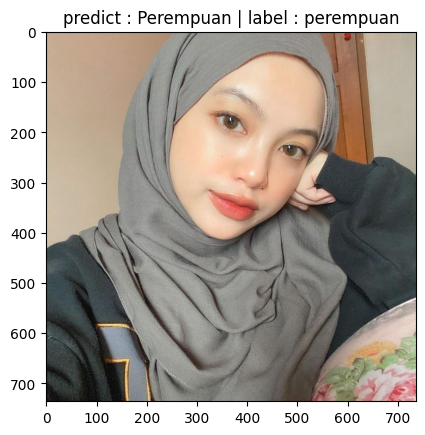

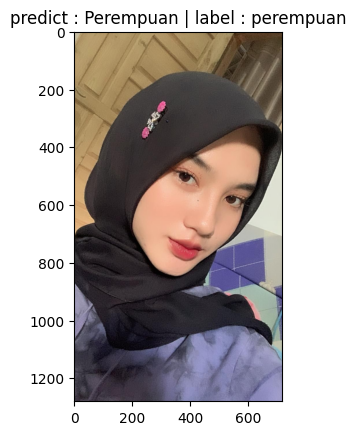

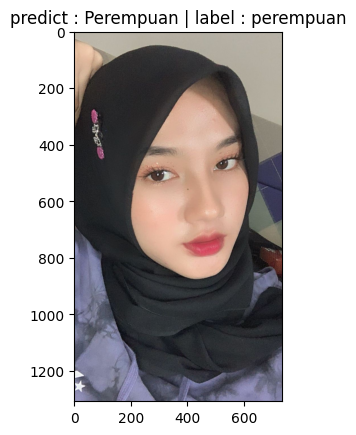

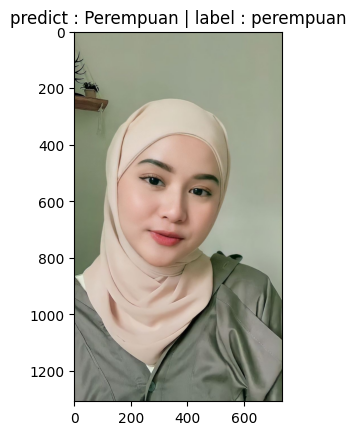

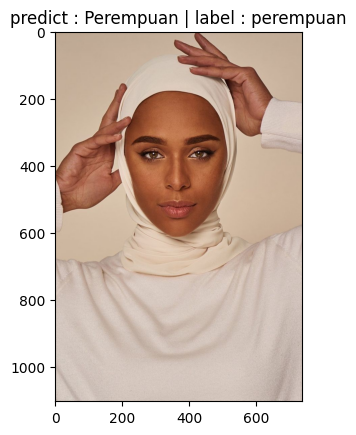

In [40]:
# 5 picture show, title berdasarkan hasil predict | label asli (in this cell ? label perempuan)

import matplotlib.pyplot as plt

import matplotlib.image as mpimg

for img in os.listdir(os.path.join(rooter, "Perempuan"))[:5]:
  t = os.path.join(rooter, os.path.join("Perempuan", img))
  img = mpimg.imread(t)
  plt.imshow(img)
  plt.title(f"predict : {output(t)} | label : perempuan")
  plt.show()

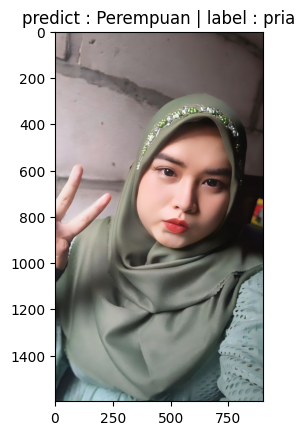

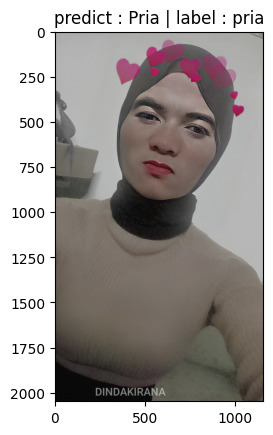

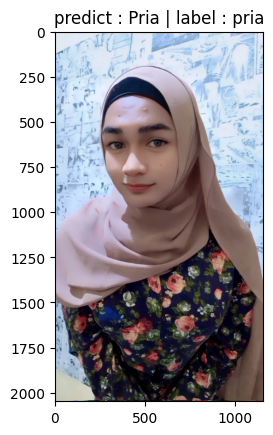

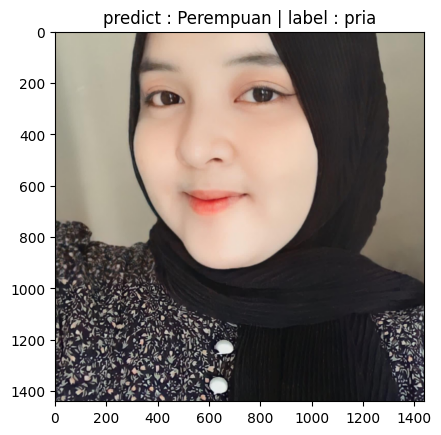

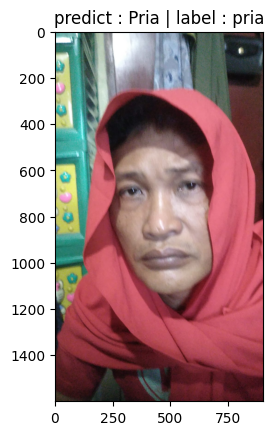

In [41]:
# 5 picture show, title berdasarkan hasil predict | label asli (in this cell ? label pria)

import matplotlib.pyplot as plt

import matplotlib.image as mpimg

for img in os.listdir(os.path.join(rooter, "Pria"))[:5]:
  t = os.path.join(rooter, os.path.join("Pria", img))
  img = mpimg.imread(t)
  plt.imshow(img)
  plt.title(f"predict : {output(t)} | label : pria")
  plt.show()